In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-45177971-303b-6d48-1a3e-3e36e39e7987)


In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-03-18 13:36:06--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  25.2MB/s    in 3.3s    

2021-03-18 13:36:10 (25.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Transfer Learning using InceptionV3 model

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape = (150, 150, 3),
    include_top = False,
    weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print(last_layer.output_shape)
last_output = last_layer.output

(None, 7, 7, 768)


In [6]:
class customCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('accuracy')>0.99:
      print("0.99 or 99% accuracy reached!")
      self.model.stop_training = True

In [7]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(
    optimizer=RMSprop(lr=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

--2021-03-18 13:36:18--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.78.216.154, 2600:1417:8000:980::e59, 2600:1417:8000:9b2::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.78.216.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   178MB/s    in 4.5s    

2021-03-18 13:36:22 (176 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


print("Number of Cat Images:", len(os.listdir('/tmp/PetImages/Cat/')))
print("Number of Dog Images:", len(os.listdir('/tmp/PetImages/Dog/')))

Number of Cat Images: 12501
Number of Dog Images: 12501


In [10]:
sets = [
    '/tmp/catsvdogs',
    '/tmp/catsvdogs/training',
    '/tmp/catsvdogs/testing',
    '/tmp/catsvdogs/training/cats',
    '/tmp/catsvdogs/training/dogs',
    '/tmp/catsvdogs/testing/cats',
    '/tmp/catsvdogs/testing/dogs']

for x in sets:
    try:
        os.mkdir(x)
        print(x, "created")
    except:
        print(x, "failed")

/tmp/catsvdogs created
/tmp/catsvdogs/training created
/tmp/catsvdogs/testing created
/tmp/catsvdogs/training/cats created
/tmp/catsvdogs/training/dogs created
/tmp/catsvdogs/testing/cats created
/tmp/catsvdogs/testing/dogs created


In [11]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files = []
    
    for File in os.listdir(SOURCE):
        path = SOURCE + File

        if os.path.getsize(path):
            all_files.append(File)
        else:
            print('{} has 0 length; removed'.format(File))
    
    n_files = len(all_files)
    split_point = int(n_files * SPLIT_SIZE)
    
    shuffled = random.sample(all_files, n_files)
    
    train_set = shuffled[:split_point]
    test_set = shuffled[split_point:]
    
    for File in train_set:
        copyfile(SOURCE + File, TRAINING + File)
        
    for File in test_set:
        copyfile(SOURCE + File, TESTING + File)

In [12]:
import random
from shutil import copyfile

CAT_SOURCE_DIR = r"/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = r"/tmp/catsvdogs/training/cats/"
TESTING_CATS_DIR = r"/tmp/catsvdogs/testing/cats/"
DOG_SOURCE_DIR = r"/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = r"/tmp/catsvdogs/training/dogs/"
TESTING_DOGS_DIR = r"/tmp/catsvdogs/testing/dogs/"
SPLIT_SIZE = .9

split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, SPLIT_SIZE)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, SPLIT_SIZE)

print( "Number of Training Cat Images: " , len(os.listdir('/tmp/catsvdogs/training/cats/')))
print( "Number of Training Dog Images: " , len(os.listdir('/tmp/catsvdogs/training/dogs/')))
print( "Number of Testing Cat Images: " , len(os.listdir('/tmp/catsvdogs/testing/cats/')))
print( "Number of Testing Dog Images: " , len(os.listdir('/tmp/catsvdogs/testing/dogs/')))

666.jpg has 0 length; removed
11702.jpg has 0 length; removed
Number of Training Cat Images:  11250
Number of Training Dog Images:  11250
Number of Testing Cat Images:  1250
Number of Testing Dog Images:  1250


In [13]:
TRAINING_DIR = '/tmp/catsvdogs/training'
train_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size = 64,
    class_mode = 'binary',
    target_size = (150, 150))

Found 22498 images belonging to 2 classes.


In [14]:
VALIDATION_DIR = '/tmp/catsvdogs/testing'
validation_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size = 64,
    class_mode = 'binary',
    target_size = (150, 150))

Found 2500 images belonging to 2 classes.


In [15]:
callbacks = customCallback()
history = model.fit_generator( train_generator, epochs=20, validation_data=validation_generator, callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
 90/352 [======>.......................] - ETA: 2:27 - loss: 0.5991 - accuracy: 0.8158

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

352/352 [==============================] - 258s 634ms/step - loss: 0.3427 - accuracy: 0.8782 - val_loss: 0.1499 - val_accuracy: 0.9336
Epoch 2/20
352/352 [==============================] - 220s 624ms/step - loss: 0.1570 - accuracy: 0.9376 - val_loss: 0.1622 - val_accuracy: 0.9384
Epoch 3/20
352/352 [==============================] - 221s 627ms/step - loss: 0.1465 - accuracy: 0.9449 - val_loss: 0.1647 - val_accuracy: 0.9392
Epoch 4/20
352/352 [==============================] - 219s 622ms/step - loss: 0.1434 - accuracy: 0.9451 - val_loss: 0.1526 - val_accuracy: 0.9432
Epoch 5/20
352/352 [==============================] - 220s 626ms/step - loss: 0.1331 - accuracy: 0.9513 - val_loss: 0.1384 - val_accuracy: 0.9484
Epoch 6/20
352/352 [==============================] - 220s 624ms/step - loss: 0.1316 - accuracy: 0.9504 - val_loss: 0.1383 - val_accuracy: 0.9468
Epoch 7/20
352/352 [==============================] - 220s 626ms/step - loss: 0.1295 - accuracy: 0.9500 - val_loss: 0.1580 - val_accura

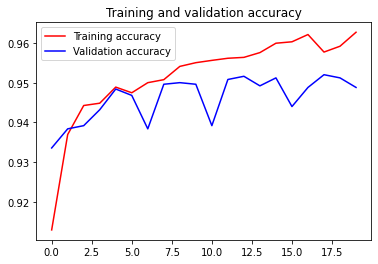

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()